# Laboratorio 3
## Universidad del Valle de Guatemala <br> Facultad de Ingeniería
#### Departamento de Ciencias de la Computación <br> Data Science - Sección 10 <br> Grupo 18 <br> - Cristian Laynez <br> - Jeyner Arango

In [118]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [119]:
# Leer la data del ejercicio anterior}
df_imp = pd.read_excel('./data/IMPORTACION-VOLUMEN-2023-05.xlsx', sheet_name='IMPORTACION',skiprows = 6,
                            nrows=270, header=0,usecols= 'A, G, I, K, L, U', engine='openpyxl').dropna()

df_imp.head()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001-01-01,0.0,194065.738095,177776.50,373963.96,566101.99
1,2001-02-01,0.0,170703.380952,123115.99,243091.07,489525.80
2,2001-03-01,0.0,161837.371429,161726.42,312084.38,575559.68
3,2001-04-01,0.0,163048.642857,127338.74,285054.89,437745.42
4,2001-05-01,0.0,171518.861905,168730.19,300913.67,552609.13


In [120]:
df_imp['Diesel'] = df_imp['Diesel bajo azufre'] + df_imp['Diesel alto azufre']
df_imp.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [121]:
df_p_nac_1 = pd.read_excel('./data/Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2021',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_1.drop(0, inplace=True)
df_p_nac_2 = pd.read_excel('./data/Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2022',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_2.drop(0, inplace=True)
df_p_nac_3 = pd.read_excel('./data/Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2023',skiprows = 7,
                            nrows=213, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_3.drop(0, inplace=True)

In [122]:
df_p_nac_1.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2021-01-01,21.91,21.11,17.61,99
2,2021-01-02,21.91,21.11,17.61,99
3,2021-01-03,21.91,21.11,17.61,99
4,2021-01-04,21.91,21.11,17.61,99
5,2021-01-05,21.91,21.11,17.61,99


In [123]:
df_p_nac_2.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2022-01-01,28.69,27.91,24.51,122
2,2022-01-02,28.69,27.91,24.51,122
3,2022-01-03,28.79,27.99,24.6,122
4,2022-01-04,28.79,27.99,24.6,122
5,2022-01-05,28.79,27.99,24.6,122


In [124]:
df_p_nac_3.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2023-01-01,32.55,30.99,33.75,122
2,2023-01-02,32.55,30.99,33.75,122
3,2023-01-03,32.56,31.42,35.31,122
4,2023-01-04,32.56,31.42,35.31,122
5,2023-01-05,32.56,31.42,35.31,122


In [125]:
df_precios = pd.concat([df_p_nac_1, df_p_nac_2, df_p_nac_3], ignore_index=True)
df_precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2021-01-01,21.91,21.11,17.61,99
1,2021-01-02,21.91,21.11,17.61,99
2,2021-01-03,21.91,21.11,17.61,99
3,2021-01-04,21.91,21.11,17.61,99
4,2021-01-05,21.91,21.11,17.61,99


In [126]:
df_consumo = pd.read_excel('./data/CONSUMO-2023-05.xlsx', sheet_name='CONSUMO',skiprows = 5,
                            nrows=282, header=1,usecols= 'A, G, K, L, U', engine='openpyxl').dropna()
df_consumo.tail()

,Fecha,Diesel bajo azufre,Gasolina regular,Gasolina superior,Diesel alto azufre
276,2023-01-01,1285932.51,804524.73,599501.29,0.0
277,2023-02-01,1226884.63,737345.64,544144.00,0.0
278,2023-03-01,1463008.43,875010.34,656941.64,0.0
279,2023-04-01,1248429.37,798128.36,585642.20,0.0
280,2023-05-01,1346554.12,866826.79,646221.20,0.0


In [127]:
df_consumo['Diesel'] = df_consumo['Diesel bajo azufre'] + df_consumo['Diesel alto azufre']
df_consumo.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [128]:
df_consumo.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel
0,2000-01-01,202645.20,308156.82,634667.06
1,2000-02-01,205530.96,307766.31,642380.66
2,2000-03-01,229499.56,331910.29,699807.25
3,2000-04-01,210680.40,315648.08,586803.98
4,2000-05-01,208164.34,319667.97,656948.20


#### Replicando algunas de las series anteriormente hechas

In [129]:
# Redefiniendo el arima
df1 = df_imp['Gasolina regular']
df2 = df_precios['Superior']
df3 = df_consumo['Diesel']

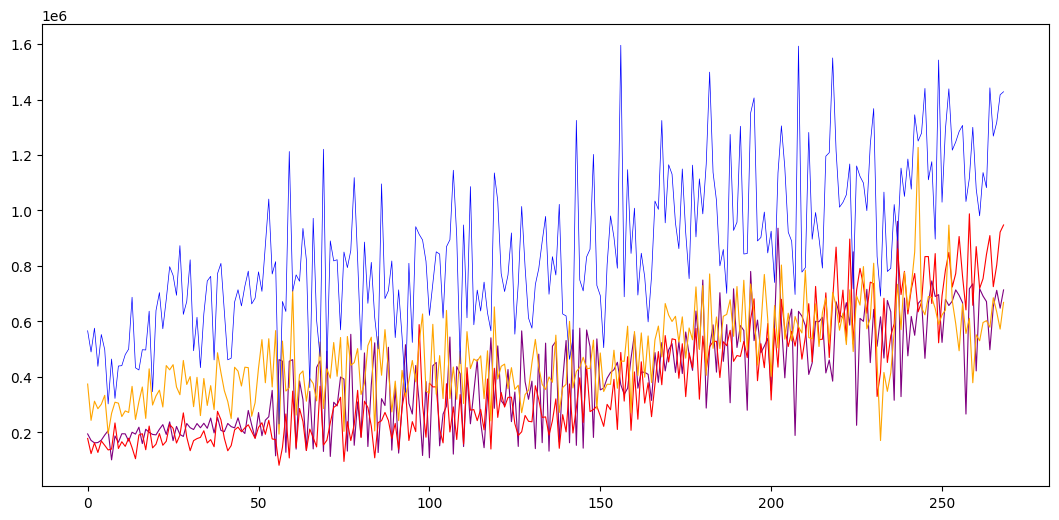

In [130]:
plt.figure(figsize=(13,6))
df_imp['Gas licuado de petróleo'].plot(color='purple', linewidth=0.8)
df_imp['Gasolina regular'].plot(color='red', linewidth=0.8)
df_imp['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_imp['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

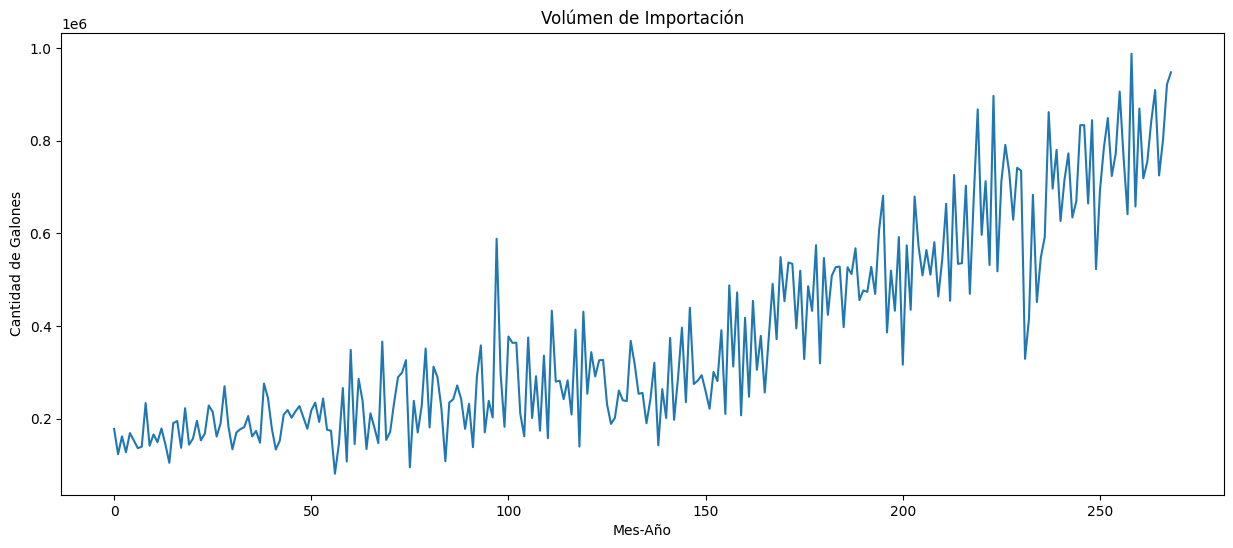

In [131]:
# Gasolina regular
plt.figure(figsize=(15,6))
plt.plot(df1)
plt.gca().set(title="Volúmen de Importación", xlabel="Mes-Año", ylabel="Cantidad de Galones")
plt.show()

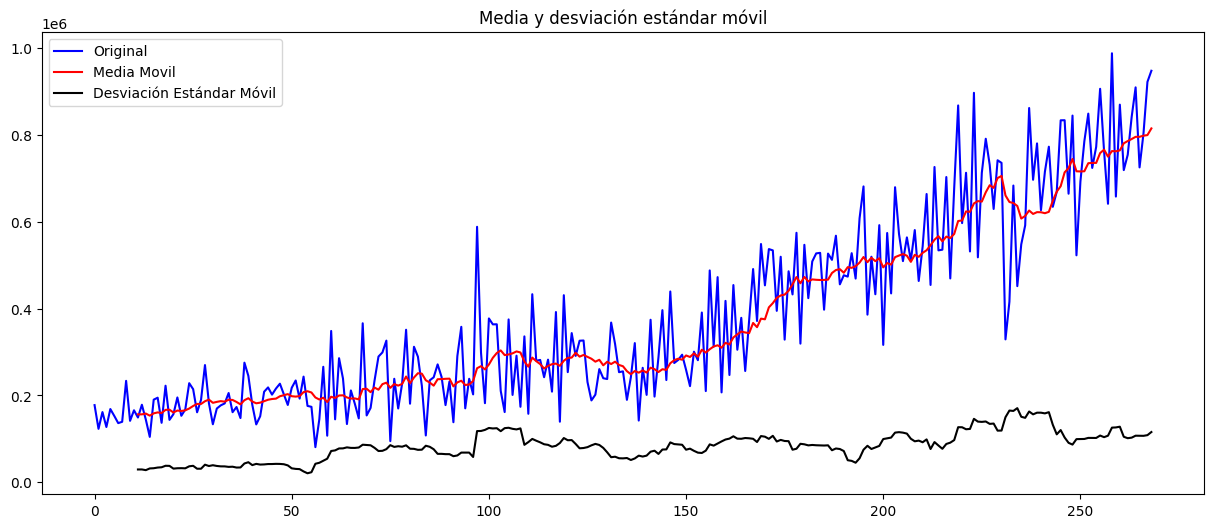

In [132]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df1.rolling(window=12).mean()
deMovil = df1.rolling(window=12).std()
# Se grafican los resultados.
plt.figure(figsize=(15,6))
original = plt.plot(df1, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

### 1. Utilizar conjuntos de entrenamiento y prueba de una de las series que utilizó en el Laboratorio 2

In [133]:
_df1 = df1

In [134]:
df1 = pd.DataFrame(df1)
df1 = np.log(df1['Gasolina regular'].values.reshape(-1, 1))
df1

array([[12.08828242],
       [11.7208822 ],
       [11.99366142],
       [11.75460606],
       [12.03605621],
       [11.93753344],
       [11.82260723],
       [11.84485217],
       [12.3615528 ],
       [11.86040984],
       [12.01878755],
       [11.91316139],
       [12.09282516],
       [11.88066967],
       [11.5586026 ],
       [12.15656197],
       [12.17988318],
       [11.82810694],
       [12.31226881],
       [11.87614395],
       [11.96372652],
       [12.18294116],
       [11.93940619],
       [12.02931584],
       [12.33828223],
       [12.27602166],
       [11.99075762],
       [12.15385731],
       [12.50611005],
       [12.11315786],
       [11.80311589],
       [12.04298803],
       [12.08513324],
       [12.10993627],
       [12.23380493],
       [11.99212252],
       [12.06351337],
       [11.90455686],
       [12.52648584],
       [12.40965141],
       [12.09171511],
       [11.80066504],
       [11.93213403],
       [12.24813954],
       [12.29453782],
       [12

In [135]:
scaler = StandardScaler()
scaler.fit_transform(df1) 

array([[-1.04186286],
       [-1.67868683],
       [-1.2058718 ],
       [-1.62023242],
       [-1.13238786],
       [-1.30315983],
       [-1.50236429],
       [-1.46380658],
       [-0.5681965 ],
       [-1.43684008],
       [-1.16232005],
       [-1.34540451],
       [-1.03398881],
       [-1.40172322],
       [-1.95997011],
       [-0.92351221],
       [-0.88308899],
       [-1.49283151],
       [-0.65362166],
       [-1.40956776],
       [-1.2577587 ],
       [-0.8777885 ],
       [-1.29991374],
       [-1.14407111],
       [-0.60853196],
       [-0.71644975],
       [-1.21090503],
       [-0.92820027],
       [-0.31763181],
       [-0.99874564],
       [-1.53614912],
       [-1.12037276],
       [-1.04732141],
       [-1.00432971],
       [-0.78962507],
       [-1.20853922],
       [-1.08479568],
       [-1.36031896],
       [-0.28231395],
       [-0.48482598],
       [-1.03591289],
       [-1.54039725],
       [-1.31251876],
       [-0.76477852],
       [-0.68435524],
       [-0

In [136]:
def get_train_validation_and_test(df):
    entrenamiento = round(0.6*len(df))
    val_prueba = round(0.2*len(df))
    test = df[(entrenamiento+val_prueba)-1:]
    validation = df[(entrenamiento):entrenamiento+val_prueba+1]
    train = df[0:entrenamiento]
    train=np.insert(train,0,0)
    train=np.reshape(train,(train.shape[0],1))
    print(len(test))
    return train, test, validation, entrenamiento, val_prueba

In [137]:
train_d1, test_d1, validation_d1, entrenamiento_df1, val_prueba_df1 = get_train_validation_and_test(df1)

55


In [138]:
from operator import concat

def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train_d1)
x_val,y_val = supervisada(validation_d1)
x_test,y_test = supervisada(test_d1)

### 2. Realizar dos modelos con configuraciones diferentes usando LSTM para predecir.

In [139]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

54

### Primer modelo

In [140]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1
modelo1.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo1.add(Dense(1))
modelo1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 1)                    12        
                                                                 
 dense_2 (Dense)             (1, 1)                    2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [141]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [142]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
161/161 [==============================] - 5s 10ms/step - loss: 149.2915 - val_loss: 166.7485
Epoch 2/50
161/161 [==============================] - 1s 3ms/step - loss: 140.9743 - val_loss: 150.3915
Epoch 3/50
161/161 [==============================] - 1s 3ms/step - loss: 122.9220 - val_loss: 132.1437
Epoch 4/50
161/161 [==============================] - 1s 6ms/step - loss: 109.9330 - val_loss: 121.9103
Epoch 5/50
161/161 [==============================] - 1s 6ms/step - loss: 101.9360 - val_loss: 114.4926
Epoch 6/50
161/161 [==============================] - 1s 5ms/step - loss: 95.3358 - val_loss: 107.6661
Epoch 7/50
161/161 [==============================] - 1s 6ms/step - loss: 89.1347 - val_loss: 101.0973
Epoch 8/50
161/161 [==============================] - 2s 9ms/step - loss: 83.1722 - val_loss: 94.7424
Epoch 9/50
161/161 [==============================] - 2s 13ms/step - loss: 77.4236 - val_loss: 88.5955
Epoch 10/50
161/161 [==============================] - 3s 16ms/step 

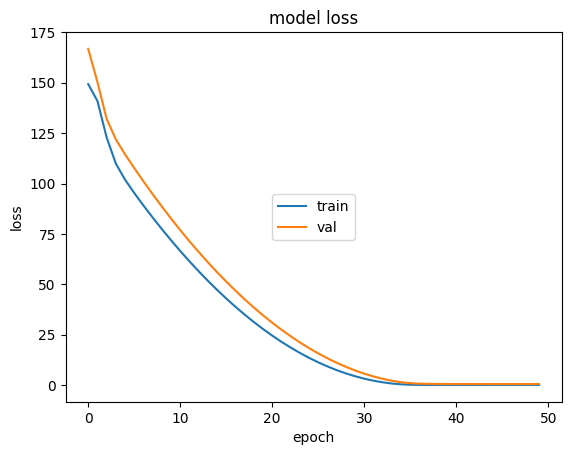

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [144]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = _df1.values , n=entrenamiento_df1)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = _df1.values , n=entrenamiento_df1 + val_prueba_df1)


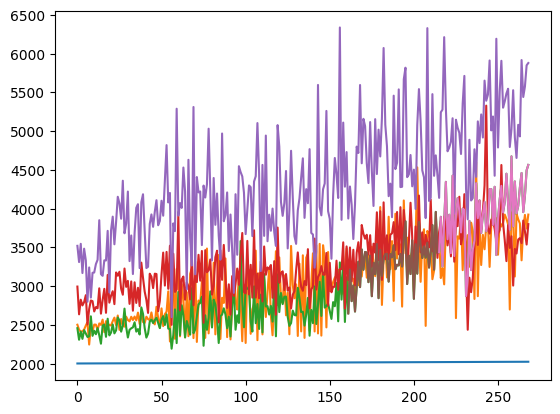

In [145]:
df_val = pd.DataFrame(prediccion_val,index=df_imp[(entrenamiento_df1):entrenamiento_df1+val_prueba_df1].index)
df_test = pd.DataFrame(prediccion_test,index=df_imp[entrenamiento_df1+len(df_val):len(df_imp)].index)

plt.plot(df_imp)
plt.plot(df_val)
plt.plot(df_test)

### Segundo modelo

In [154]:
modelo2 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1
modelo2.add(LSTM(lote, batch_input_shape=(lote,paso,caracteristicas),stateful=True))
modelo2.add(Dense(2))
modelo2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (1, 1)                    12        
                                                                 
 dense_5 (Dense)             (1, 2)                    4         
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [155]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [156]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=2
)

Epoch 1/100


161/161 - 4s - loss: 149.3497 - val_loss: 166.2534 - 4s/epoch - 28ms/step
Epoch 2/100
161/161 - 1s - loss: 142.6911 - val_loss: 156.9694 - 762ms/epoch - 5ms/step
Epoch 3/100
161/161 - 1s - loss: 134.0426 - val_loss: 148.6400 - 722ms/epoch - 4ms/step
Epoch 4/100
161/161 - 1s - loss: 126.6558 - val_loss: 140.9110 - 793ms/epoch - 5ms/step
Epoch 5/100
161/161 - 1s - loss: 119.5377 - val_loss: 133.3894 - 866ms/epoch - 5ms/step
Epoch 6/100
161/161 - 1s - loss: 112.6263 - val_loss: 126.0749 - 808ms/epoch - 5ms/step
Epoch 7/100
161/161 - 1s - loss: 105.9216 - val_loss: 118.9673 - 691ms/epoch - 4ms/step
Epoch 8/100
161/161 - 1s - loss: 99.4235 - val_loss: 112.0666 - 927ms/epoch - 6ms/step
Epoch 9/100
161/161 - 1s - loss: 93.1319 - val_loss: 105.3730 - 625ms/epoch - 4ms/step
Epoch 10/100
161/161 - 1s - loss: 87.0469 - val_loss: 98.8862 - 686ms/epoch - 4ms/step
Epoch 11/100
161/161 - 1s - loss: 81.1684 - val_loss: 92.6065 - 638ms/epoch - 4ms/step
Epoch 12/100
161/161 - 1s - loss: 75.4966 - val_lo

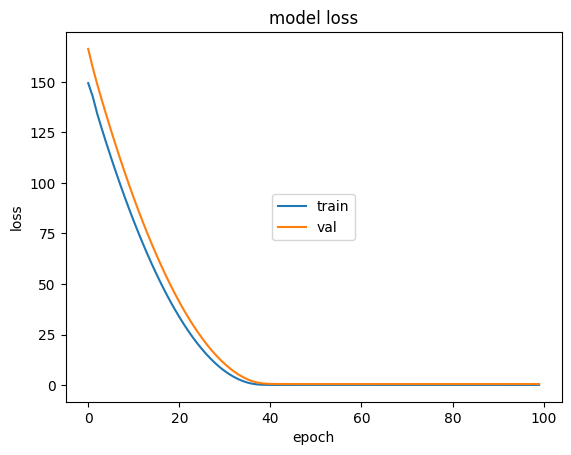

In [157]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [158]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = _df1.values , n=entrenamiento_df1)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = _df1.values , n=entrenamiento_df1 + val_prueba_df1)

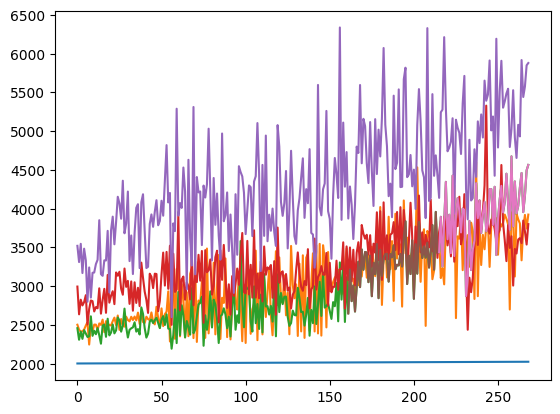

In [159]:
df_val = pd.DataFrame(prediccion_val,index=df_imp[(entrenamiento_df1):entrenamiento_df1+val_prueba_df1].index)
df_test = pd.DataFrame(prediccion_test,index=df_imp[entrenamiento_df1+len(df_val):len(df_imp)].index)

plt.plot(df_imp)
plt.plot(df_val)
plt.plot(df_test)

### 3. Contestar a las siguientes preguntas:

#### ¿Cuál predijo mejor?

Según los resultados de los dos modelos dieron los mismos resultados. Sin embargo donde hubo menor perdida de valores fue en el segundo modelo por aumentar las "epocas".

#### ¿Son mejores que los modelos creados en el laboratorio pasado?

Ambos resultados son buenos. Sin embargo se condisera que con estos modelos se pueden considerar mejores ya que no hay tanta perdido como los modelos creados en el laboratorio anterior.

#### ¿Cómo lo determinaron?

Se determino por medio de las gráficas de perdida y los resultados dados.